In [226]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import skimage
from skimage.segmentation import clear_border, watershed
from skimage.feature import peak_local_max
from skimage.morphology import reconstruction, local_minima
from skimage import color
from scipy import ndimage as ndi

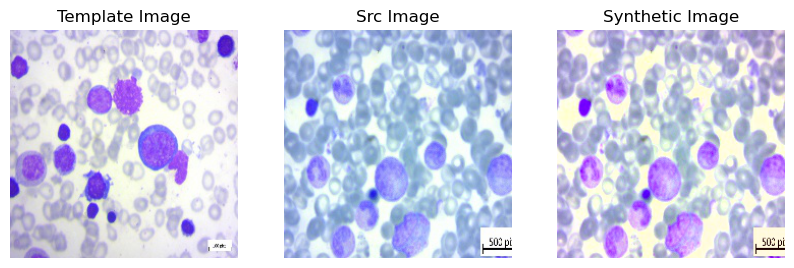

In [93]:
ref_img_path = "data/train/Benign/002.jpg"

def img_norm(src_img, img_template, verbose=False):
  """ Perform color transfer according to the method described 
  by Zhang C, Xiao X, Li X, Chen YJ, Zhen W, Chang J, Zheng C, Liu Z. 
  White blood cell segmentation by color-space-based k-means clustering. 
  Sensors (Basel). 2014 Sep 1;14(9):16128-47
  
  Parameters:
  -----------
    src_img : array-like
      image to adjust through color transfer
      
    img_template : array-like
      image that would represent a golden standard
  
  Returns:
  --------
    img : array-like
      image array of color-adjusted src_img
  
  """
  
  # 1. Transform the RGB color space of the input image and 
  #    the template image to Lab color space
  src_lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
  src_lc,src_ac,src_bc = cv2.split(src_lab)
  
  tmp_lab = cv2.cvtColor(img_template, cv2.COLOR_BGR2LAB)
  tmp_lc,tmp_ac,tmp_bc = cv2.split(tmp_lab)
  
  # 2. Compute the mean value and standard deviation of the
  #    input image and the template image in Lab color space
  # 3. Subtract the mean value from all the pixels
  src_lcp = src_lc - np.mean(src_lc)
  src_acp = src_ac - np.mean(src_ac)
  src_bcp = src_bc - np.mean(src_bc)
  
  tmp_lcp = tmp_lc - np.mean(tmp_lc)
  tmp_acp = tmp_ac - np.mean(tmp_ac)
  tmp_bcp = tmp_bc - np.mean(tmp_bc)
  
  # 4. Scale the pixel points of each color component of the 
  #    synthetic image by factors determined by the ratio of 
  #    respective standard deviations
  sig_src_lc = np.std(src_lc)
  sig_src_ac = np.std(src_ac)
  sig_src_bc = np.std(src_bc)
  
  sig_tmp_lc = np.std(tmp_lc)
  sig_tmp_ac = np.std(tmp_ac)
  sig_tmp_bc = np.std(tmp_bc)
  
  img_lc = src_lcp * (sig_tmp_lc / sig_src_lc) + np.mean(tmp_lc)
  img_ac = src_acp * (sig_tmp_ac / sig_src_ac) + np.mean(tmp_ac)
  img_bc = src_bcp * (sig_tmp_bc / sig_src_bc) + np.mean(tmp_bc)
  
  img = np.stack((img_lc, img_ac, img_bc), axis=-1)
  # clip image
  #img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
  img = np.clip(img, 1, 255)
  img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  
  if verbose:
    fig, axs = plt.subplots(1,3,figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(img_template, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0)
    axs[0].title.set_text('Template Image')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0)
    axs[1].title.set_text('Src Image')
    axs[1].axis('off')
    axs[2].imshow(img.astype(np.float32)/255.0)
    axs[2].title.set_text('Synthetic Image')
    axs[2].axis('off')
    
  return img
  
# retrieve template image
ref_img_path = "data/train/Benign/028.jpg"
img_template = cv2.imread(ref_img_path)
src_img = cv2.imread("data/train/Benign/048.jpg")

_ = img_norm(src_img, img_template, verbose=True)

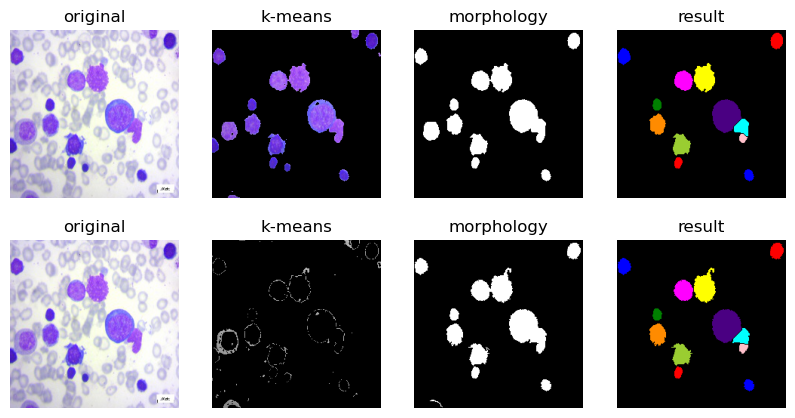

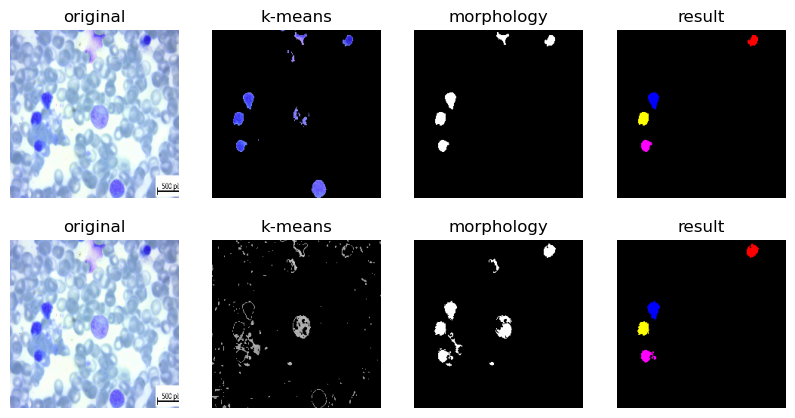

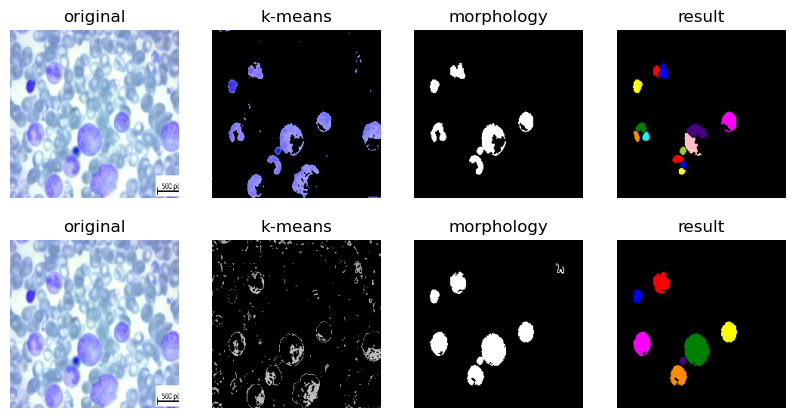

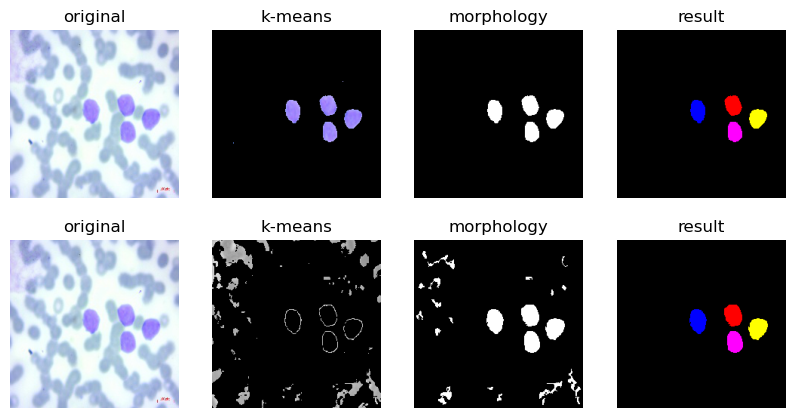

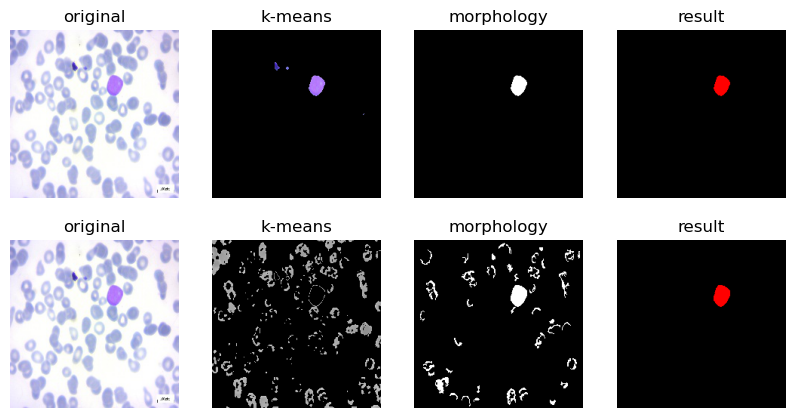

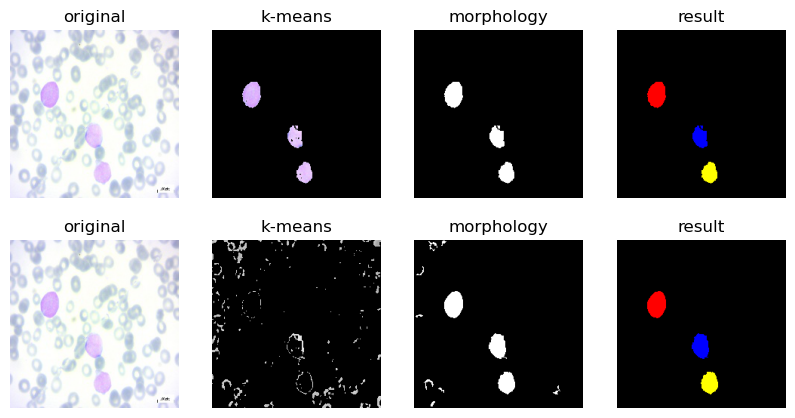

In [392]:
def img_seg_lab(path, verbose=False):
  """ Segment nucleus from the blood smear images for later feature
      extraction. Does source image norming through color transfer,
      so make sure that ref_img_path is defined globally for template
      image. This segmentation mostly follows the approach by Acharya and Kumar:
      Acharya, V., Kumar, P. Detection of acute lymphoblastic leukemia using 
      image segmentation and data mining algorithms. 
      Med Biol Eng Comput 57, 1783–1811 (2019). https://doi.org/10.1007/s11517-019-01984-1
      
      Parameters:
      -----------
        path : str
          path to the image file
          
      Returns:
      --------
        (nlabels,clabels) : tuple
          labels for nuleus and cytoplasm
    
  """
  
  # apply median blur to reduce noise
  def preprocess_helper(raw_img):
    # apply median blur to reduce image noise
    img = cv2.medianBlur(raw_img, 3)
    
    return img
  
  # img to binary with a given threshold
  def im2bin_threshold(src_img, threshold_float):
    img = src_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 255*threshold_float, 255, cv2.THRESH_BINARY)[1]
    
    return img
  
  # bgr to rgb and norm to 0,1
  def bgr2rgb_float(src_img):
    return cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
  
  
  def extendedmin(img, H):
    """ Implementation of mathworks function imextendedmin
    https://stackoverflow.com/questions/70251361/imextendedmin-and-imimposemin-functions-in-python-for-watershed-seeds-from-dista
    """
    mask = img.copy() 
    marker = mask + H 
    hmin =  reconstruction(marker, mask, method='erosion')
    return local_minima(hmin)
  
  def imposemin(img, minima):
    """ Implementation of mathworks function imimposemin
    https://stackoverflow.com/questions/70251361/imextendedmin-and-imimposemin-functions-in-python-for-watershed-seeds-from-dista
    """
    marker = np.full(img.shape, np.inf)
    marker[minima == 1] = 0
    mask = np.minimum((img + 1), marker)
    return reconstruction(marker, mask, method='erosion')
  
  # watershed to split connected blobs
  def watershed_seg(src_img_bin, min_distance=5, compactness=0, split=False):
    """ Implements watershed segmentation of a given image of nucleus
        with adjustment of local minima based on blog article by S. Eddins (2013)
        and implementation examples adopted from 
        https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html
        accessed April, 2023,
        https://stackoverflow.com/questions/41175803/counting-number-of-cells-and-nucleus-using-watershed-skikit-image
        accessed April, 2023,
        https://stackoverflow.com/questions/70251361/imextendedmin-and-imimposemin-functions-in-python-for-watershed-seeds-from-dista
      
        Parameters:
        -----------
          src_img_bin : array-like
            source image
            
          min_distance : int
            minimum allowed distance separating peaks
            
          compactness : float
            control basin shapes for tuning
            
          split : bool
            whether to apply region segmenting line
       
    """
    
    distance = ndi.distance_transform_edt(src_img_bin)
    coords = peak_local_max(distance, min_distance=min_distance, labels=src_img_bin)
    
    # "The "raw" watershed transform is known for its tendency to "oversegment" an image. 
    # The reason is something I mentioned above: each local minimum, no matter how small, 
    # becomes a catchment basin. A common trick, then, in watershed-based segmentation methods 
    # is to filter out tiny local minima" (S.Eddins, "Watershed transformquestion from tech support", 
    # Nov 19, 2013, 
    # https://blogs.mathworks.com/steve/2013/11/19/watershed-transform-question-from-tech-support/
    d_mask = extendedmin(distance,2)
    
    d_updated = imposemin(distance,d_mask)
    
    mask = np.zeros(d_updated.shape, dtype='bool')
    mask[tuple(coords.T)] = True
    markers = ndi.label(mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-d_updated, markers, mask=src_img_bin, watershed_line=split, compactness=compactness)
    
    # filter out tiny regions
    # apply area opening with number of pixels (50)
    # to remove small particles in the selected zones
    for label in np.unique(labels):
      if label == 0:
        continue

      mask = np.zeros(src_img_bin.shape, dtype="uint8")
      mask[labels == label] = 255
      mask_updated = skimage.morphology.area_opening(mask, area_threshold=50, connectivity=8)
      
      if np.max(mask_updated) == 0:
        labels[labels == label] = 0
            
    return labels
    
  # load image
  raw_img = cv2.imread(path)
  
  # load template
  img_template = cv2.imread(ref_img_path)
  
  #syn_img = img_norm(raw_img, img_template)
  
  syn_img = raw_img
  
  img_shape = raw_img.shape
  channel_shape = raw_img.shape[:2]
  
  # preprocess image with median blur
  pre_img = syn_img#preprocess_helper(syn_img)
  
  # convert to LAB
  lab_img = cv2.cvtColor(pre_img, cv2.COLOR_BGR2LAB)
  lc,ac,bc = cv2.split(lab_img)

  # vectorize pixels keeping a,b channels
  vec = np.stack((ac,bc), axis=-1).reshape(-1,2)
  
  # k-medoids
  #km = KMedoids(n_clusters=4, init='k-medoids++', method='pam', max_iter=20).fit(vec)
  km = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec)
  labs = np.unique(km.labels_)
  
  # pick the cluster with lowest intensity in red (channel 0 in vec)
  cl = labs[np.argmax([ np.mean(vec[km.labels_ == lab,0]) for lab in labs ])]
  
  # pick the cluster with 2nd lowest intensity in red (channel 0 in vec)
  cl2 = labs[np.argsort([ np.mean(vec[km.labels_ == lab,0]) for lab in labs ])[-2]]
  
  # create mask for highest intensity cluster
  mask = np.ones(vec.shape[0])
  
  mask[(km.labels_ != cl)] = 0
  mask = mask.reshape(raw_img.shape[:2])
  
  img = raw_img.copy()
  img[(km.labels_ != cl).reshape(channel_shape),:] = 0
  
  if verbose:
    fig, axs = plt.subplots(2,4,figsize=(10,5))
    axs[0,0].imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)
    axs[0,0].axis('off')
    axs[0,0].title.set_text('original')
    axs[1,0].imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)
    axs[1,0].axis('off')
    axs[1,0].title.set_text('original')
    axs[0,1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)
    axs[0,1].axis('off')
    axs[0,1].title.set_text('k-means')
  
  # apply morphology
  # 1. gray scale
  # 2. convert to binary and threshold at 0.1
  img_bin = im2bin_threshold(img, 0.1)
  
  # apply area opening with number of pixels (100)
  # to remove small particles in the selected zones
  img_bin = skimage.morphology.area_opening(img_bin, area_threshold=100, connectivity=8)
  
  # apply area opening with number of pixels (15)
  # to remove small particles in the non-selected zones
  img_bin = ~skimage.morphology.area_opening(~img_bin, area_threshold=15, connectivity=8)
  
  # save copy for using with cytoplasm extraction step
  img_nbin = img_bin.copy()
  
  # clear border connected blobs
  # they mostly do not contribute
  img_bin = clear_border(img_bin)
  
  if verbose:
    axs[0,2].imshow(img_bin, vmin=0, vmax=255, cmap='gray')
    axs[0,2].axis('off')
    axs[0,2].title.set_text('morphology')
    
  # split connected blobs with watersheed algorithm
  nucseg_labels = watershed_seg(img_bin, compactness=0, split=True)
  
  # extract cytoplasm
  # given k-means mask cl2
  # create mask for highest intensity cluster
  mask2 = np.ones(vec.shape[0])
  
  mask2[(km.labels_ != cl2)] = 0
  mask2 = mask2.reshape(raw_img.shape[:2])
  
  # create image filtering out non-cl2 objects
  img_c = raw_img.copy()
  img_c[(km.labels_ != cl2).reshape(channel_shape),:] = 0
  
  # make a copy of LAB representation for k-means for cytoplasm extraction
  lc2 = lc.copy()
  ac2 = ac.copy()
  bc2 = bc.copy()
  
  lc2[(km.labels_ != cl2).reshape(channel_shape)] = 0
  ac2[(km.labels_ != cl2).reshape(channel_shape)] = 0
  bc2[(km.labels_ != cl2).reshape(channel_shape)] = 0

  # vectorize pixels keeping a,b channels
  vec2 = np.stack((ac2,bc2), axis=-1).reshape(-1,2)
  
  # run 3-cluster classification
  km2 = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init="auto").fit(vec2)
  labs2 = np.unique(km2.labels_)
  
  # pick the cluster with lowest intensity in red (channel 0 in vec2)
  cl3 = labs2[np.argmax([ np.mean(vec2[km2.labels_ == lab,0]) for lab in labs2 ])]
  
  # calculate the mask
  mask2 = np.ones(vec2.shape[0])
  mask2[(km2.labels_ != cl3)] = 0
  mask2 = mask2.reshape(raw_img.shape[:2])
  
  # create image filtering out non-cl3 objects
  img_c = raw_img.copy()
  img_c[(km2.labels_ != cl3).reshape(channel_shape),:] = 0
  
  # convert to grayscale
  img_cgray = img_c.copy()
  img_cgray = cv2.cvtColor(img_cgray, cv2.COLOR_BGR2GRAY)
  
  if verbose:
    axs[1,1].imshow(img_cgray, vmin=0, vmax=255, cmap='gray')
    axs[1,1].axis('off')
    axs[1,1].title.set_text('k-means')
  
  # 
  # applying contrast correction and morphology based on 
  # second part of cytoplasm extraction algorithm (Acharya and Kumar, 2019)
  #
  
  # adaptive hist equalization
  ahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  img_cgray = ahe.apply(img_cgray)
  img_cgray = cv2.equalizeHist(img_cgray)
  
  # otsu thresholding
  img_cbin = cv2.threshold(img_cgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  
  # fill holes
  #img_cbin = ndi.binary_fill_holes(img_cbin/255)*255
  
  # combine with img_nbin to help with morphology
  # we will substract it after
  img_wbcbin = np.maximum(img_cbin.copy(), img_nbin.copy())
  
  # clear border connected blobs
  # they mostly do not contribute
  img_wbcbin = clear_border(img_wbcbin)
  
  # apply area opening with number of pixels (20)
  # to remove small artifacts
  img_wbcbin = skimage.morphology.area_opening(img_wbcbin, area_threshold=20, connectivity=8)
  
  # apply area opening with number of pixels (150)
  # to remove small particles in the non-selected zones - close holes
  img_wbcbin = ~skimage.morphology.area_opening(~img_wbcbin, area_threshold=150, connectivity=8)
  
  # split connected blobs with watersheed algorithm
  cytseg_labels = watershed_seg(img_wbcbin, min_distance=7, compactness=0, split=True)
  
  # remove labeled regions that do not overlap between nucleus and cytoplasm regions
  # here the assumption is that each cell has both components identified
  
  for clab in np.unique(cytseg_labels):
    # skip background
    if clab == 0:
      continue
     
    # if max label id within nucleus map is 0 -> no overlap
    # zero out this cytoplasm label
    if np.max(nucseg_labels[cytseg_labels == clab]) == 0:
      cytseg_labels[cytseg_labels == clab] = 0
      
  for nlab in np.unique(nucseg_labels):
    # skip background
    if nlab == 0:
      continue
     
    # if max label id within cytoplasm map is 0 -> no overlap
    # zero out this nucleus label
    if np.max(cytseg_labels[nucseg_labels == nlab]) == 0:
      nucseg_labels[nucseg_labels == nlab] = 0
  
    
  if verbose:
    axs[1,2].imshow(img_wbcbin, vmin=0, vmax=255, cmap='gray')
    axs[1,2].axis('off')
    axs[1,2].title.set_text('morphology')
  
  # visualize watershed basins/segmentation regions
  img_split = color.label2rgb(nucseg_labels, bg_label=0)
  img_csplit = color.label2rgb(cytseg_labels, bg_label=0)
    
  if verbose:
    axs[0,3].imshow(img_split, vmin=0, vmax=255)
    axs[0,3].axis('off')
    axs[0,3].title.set_text('result')
    axs[1,3].imshow(img_csplit, vmin=0, vmax=255)
    axs[1,3].axis('off')
    axs[1,3].title.set_text('result')
  
  if verbose:
    plt.show()
  
  return nucseg_labels, cytseg_labels
  
_ = img_seg_lab('data/train/Benign/028.jpg', verbose=True)
_ = img_seg_lab('data/train/Benign/044.jpg', verbose=True)
_ = img_seg_lab('data/train/Benign/048.jpg', verbose=True)
_ = img_seg_lab('data/train/Early/010.jpg', verbose=True)
_ = img_seg_lab('data/train/Pre/010.jpg', verbose=True)
_ = img_seg_lab('data/train/Pro/010.jpg', verbose=True)

In [117]:
# define base path and Path objects for different image sets
img_path_base = 'data/'
path_train = Path(img_path_base) / 'train/'
path_valid = Path(img_path_base) / 'valid/'
path_test = Path(img_path_base) / 'test/'

train_labels = [ pobj.parts[-1].lower() for pobj in path_train.iterdir() if pobj.is_dir() ]
print("Labels: ", train_labels)

Labels:  ['early', 'pro', 'benign', 'pre']


In [118]:
# image paths for each set
train_set = sorted([ pobj for dobj in train_labels for pobj in (path_train / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

valid_set = sorted([ pobj for dobj in train_labels for pobj in (path_valid / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

test_set = sorted([ pobj for dobj in train_labels for pobj in (path_test / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

In [119]:
# create temp verification set for demonstration
ver_set = [ str(pobj) for pobj in train_set if pobj.parts[-1] in ['001.jpg','002.jpg'] ]
ver_set

['data/train/Benign/001.jpg',
 'data/train/Benign/002.jpg',
 'data/train/Early/001.jpg',
 'data/train/Early/002.jpg',
 'data/train/Pre/001.jpg',
 'data/train/Pre/002.jpg',
 'data/train/Pro/001.jpg',
 'data/train/Pro/002.jpg']

In [124]:
# read images, convert to [0, 1] floats
imgs = [ cv2.cvtColor(cv2.imread(sobj), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0 for sobj in ver_set ]
print("Images value range:",(np.min(imgs[0]), np.max(imgs[0])))

Images value range: (0.11372549, 1.0)


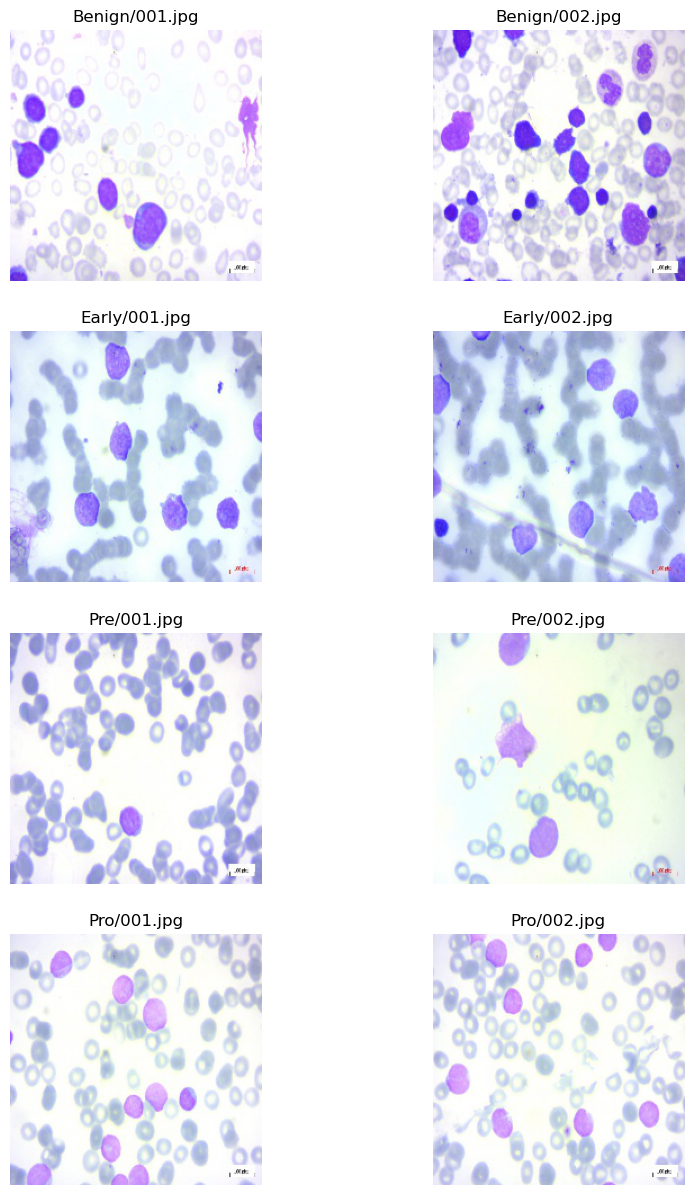

In [125]:
fig, axs = plt.subplots(4,2,figsize=(10,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(imgs[i])
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()

In [ ]:
# pre-process images
proc_imgs = [ img_seg(img_path) for img_path in ver_set ]  

In [ ]:
fig, axs = plt.subplots(4,2,figsize=(15,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(proc_imgs[i], cmap='gray')
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()

In [ ]:
img_seg_lab('data/train/Benign/028.jpg', verbose=True)